# Applications of Data Science

# Lab 1

# Exploring Time Series Data

## Overview

Time series models are used in a wide range of applications, particularly for forecasting. 

This notebook contains lab material to familarize yourself with key aspects of time series analysis. You will perform analyses on a time series of California dairy data. Specifically, you will explore the structure of the time series and forecast the monthly production of fresh milk in the state of California. 

This exploration is performed in two steps:

- Explore the characteristics of the time series data.
- Decompose the time series of monthly milk production into trend, seasonal components, and remainder components. 
- Apply time series models to the remainder component of the time series.
- Forecast the production of monthly milk production for a 12 month period. 

## Load and Examine the Data

As a first step, ensure that you have uploaded the **cadairydata.csv** file as a new dataset in your Azure Machine Learning workspace, and then execute the code below to load the data set into a dataframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv("cadairydata.csv", index_col=None)
df.head()

,Unnamed: 0,Year.Month,Month.Number,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price
0,1,1995.01,1,1995,Jan,4.370,51.595,2.112,0.9803
1,2,1995.02,2,1995,Feb,3.695,56.086,1.932,0.8924
2,3,1995.03,3,1995,Mar,4.538,68.453,2.162,0.8924
3,4,1995.04,4,1995,Apr,4.280,65.722,2.130,0.8967
4,5,1995.05,5,1995,May,4.470,73.730,2.227,0.8967


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 9 columns):
Unnamed: 0           228 non-null int64
Year.Month           228 non-null float64
Month.Number         228 non-null int64
Year                 228 non-null int64
Month                228 non-null object
Cotagecheese.Prod    228 non-null float64
Icecream.Prod        228 non-null float64
Milk.Prod            228 non-null float64
N.CA.Fat.Price       228 non-null float64
dtypes: float64(5), int64(3), object(1)
memory usage: 16.1+ KB


Perform the following steps:

- Data is sorted in asecending order of year and month.
- A datetime object is created. 
- Some unnecessary columns are removed from the data frame (we will use only milk production for plot)

In [4]:
df = df.sort_values(by=['Year', 'Month.Number'])
df = df.drop(['Unnamed: 0', 'Year.Month', 'Month', 'Cotagecheese.Prod', 'Icecream.Prod', 'N.CA.Fat.Price'], axis=1)
df.head()

,Month.Number,Year,Milk.Prod
0,1,1995,2.112
1,2,1995,1.932
2,3,1995,2.162
3,4,1995,2.130
4,5,1995,2.227


In [5]:
# create datetime object
df["day"] = pd.Series([1]*len(df))
df = df.rename(columns={"Month.Number": "Month"})
df["date_time"] = pd.to_datetime(df[["Year", "Month", "day"]])

In [6]:
df.head()

,Month,Year,Milk.Prod,day,date_time
0,1,1995,2.112,1,1995-01-01
1,2,1995,1.932,1,1995-02-01
2,3,1995,2.162,1,1995-03-01
3,4,1995,2.130,1,1995-04-01
4,5,1995,2.227,1,1995-05-01


In [7]:
# df["date_time"].iloc[0:20]

## Create a Time Series Plot

Now that you have examined the data frame, you will create a time series plot of milk production. 

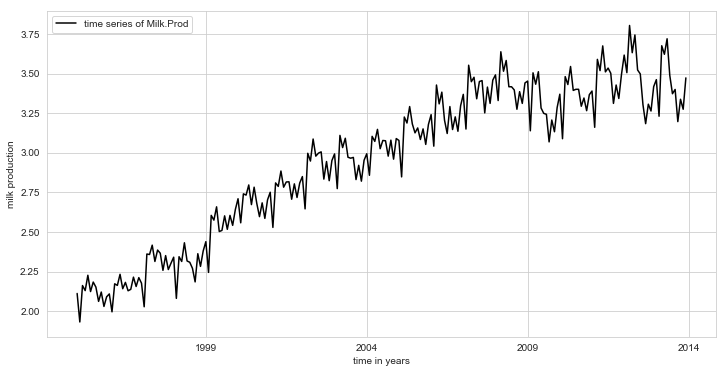

In [8]:
def plot(df, col = 'Milk.Prod'):
    fig = plt.figure(figsize=(12,6))
    fig.clf()
    ax = fig.gca()
    df.plot(x = 'date_time', y = col, c="black", ax=ax, label = f'time series of {col}')
    ax.set_ylabel('milk production')
    ax.set_xlabel('time in years')
plot(df)

The production of milk is shown on the vertical scale and the date is on the horizontal scale. 

For most of the time period shown, the production of milk increased year over year. However, there is a decline in milk production starting in 2009 as a results of the recession. Also, notice that this time series exhibits a strong seasonal component with an annual cycle. 


## Statistical Properties of the Time Series

Having examined the time series of milk production, we will now explore some statistical properties of the time series. 

Autocorrelation is a fundamental property of time series. The **Autocorrelation Function** or ACF provides information on the dependency of the time series values of previous values. Later, we will use the results of ACF analysis to estimate the order of moving average processes.The **Partial autocorrelation Function** or PACF, measures the correlation of the time series with its own lag values. Later in this lab you will use an  PACF to estimate the order of an autoregressive process. 

Execute the code in the following cell and examine the ACF of the milk production time series. 

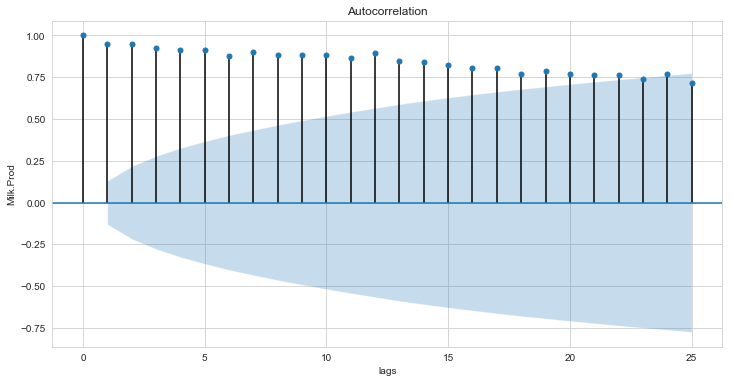

In [9]:
def acf(df, col):
    from statsmodels.graphics.tsaplots import plot_acf
    fig = plt.figure(figsize=(12,6))
    fig.clf()
    ax = fig.gca()
    plot_acf(df[col], ax=ax, lags=25, alpha=.05, fft=True, unbiased=True)
    ax.set_xlabel('lags')
    ax.set_ylabel(col)
acf(df, 'Milk.Prod')

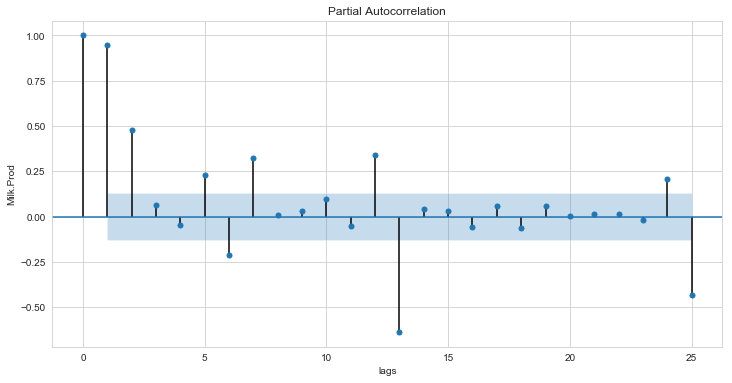

In [10]:
def pacf(df, col):
    from statsmodels.graphics.tsaplots import plot_pacf
    fig = plt.figure(figsize=(12,6))
    fig.clf()
    ax = fig.gca()
    plot_pacf(df[col], ax=ax, lags=25, alpha=.05)
    ax.set_xlabel('lags')
    ax.set_ylabel(col)
pacf(df, 'Milk.Prod')

Note that the values of the ACF at the various lags decays only slowly. This indicates there is considerable serial correlation between the time series values at the various lags, mostly likely from the trend. 

Plotting a histogram provides information on the distribution of values of the time series. Execute the code in the cell below and examine the histogram.

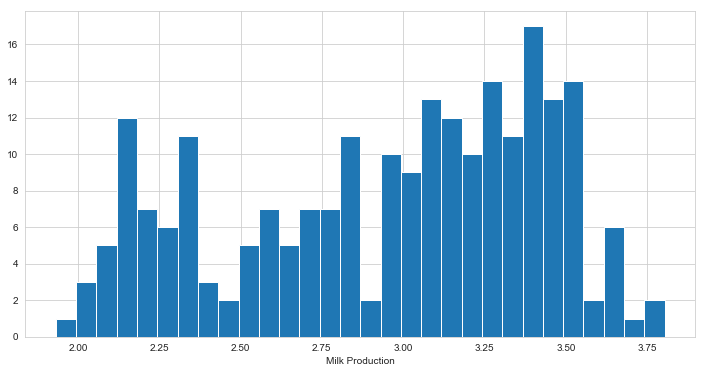

In [11]:
def hist(df, col, bins):
    fig = plt.figure(figsize=(12,6))
    fig.clf()
    ax = fig.gca()
    df[col].hist(bins = bins, ax=ax)
    ax.set_xlabel('Milk Production')
hist(df, 'Milk.Prod', 30)

## Simple Moving Average Decomposition of the Time Series

Time series are typically decomposed into three components: trend, seasonal, and the remainder, or residual. Trend can be modeled by several methods. You will start by decomposing the time series using a simple moving average model. 

The code in the cell below uses moving window method to compute the average of the time series over specified span, or order of the operator. As the moving window operator moves over the data, the average of the values in the windows is calculated. Execute the cell to load the function.

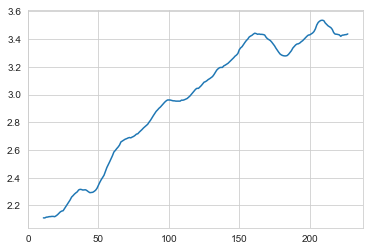

In [12]:
def sma(df, col, window):
    new_col = col + '_' + str(window)
    df[new_col] = df[col].rolling(window = window).mean()
sma(df, 'Milk.Prod', 12)
df['Milk.Prod_12'].plot()

Once the trend has been removed, the seasonal component must be modeled and removed. The function in the cell below computes the seasonal component as a function of the month of the year using a linear model. The **0** in the model formula supresses the intercept term. Since 12 monthly factors are used to model seasonal variation, the model would be over-determined if an intercept was included. 

Execute the code in the cell to load the function.

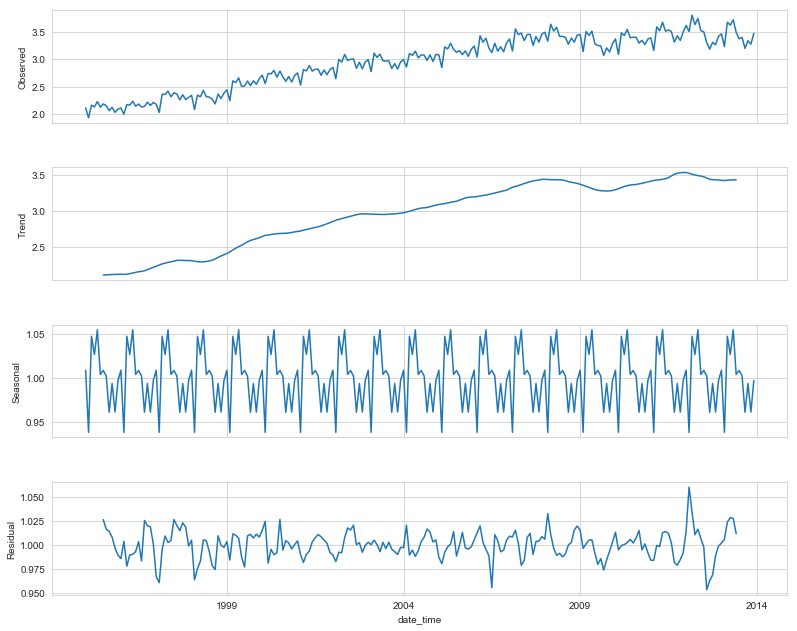

In [13]:
def naive_decompose(df, col, model):
    from statsmodels.tsa.seasonal import seasonal_decompose
    df.index = df['date_time'] # seasonal_decompose requires a datetime index
    series = df[col]
    results = seasonal_decompose(series, model=model)
    results.plot()
    ax=plt.gca()
    fig=plt.gcf()
    fig.set_size_inches(12,10)
#     fig.set_facecolor("b")
#     ax.set_facecolor('b')
    return results
rr = naive_decompose(df, 'Milk.Prod', 'multiplicative')


We can see the trend and seasonal components clearly separated in the above plots. The remainder plot looks fairly random, as expected. But, is the remainder actually stationary?  To test for stationarity of the remainder, lets plot the ACF by executing the code in the cell below. 

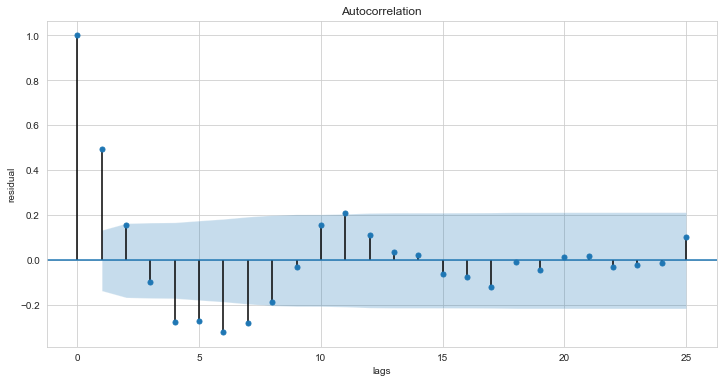

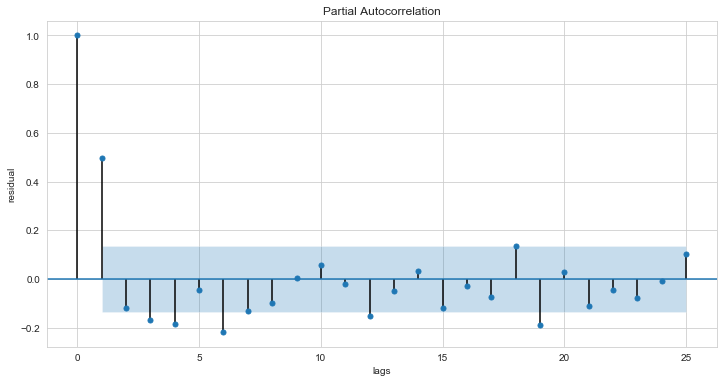

In [14]:
# Plot ACF and PACF 
# add residual series to the original DF
df['residual'] = rr.resid
df = df.dropna(axis=0)
# df_res = pd.DataFrame(rr.resid)
# df_res = df_res.dropna(axis=0)
acf(df, 'residual')
pacf(df, 'residual')

In [15]:
df.head()

,Month,Year,Milk.Prod,day,date_time,Milk.Prod_12,residual
date_time,,,,,,,
1995-12-01,12,1995,2.091,1,1995-12-01,2.110583,0.989159
1996-01-01,1,1996,2.109,1,1996-01-01,2.110333,0.985808
1996-02-01,2,1996,1.996,1,1996-02-01,2.115667,1.003770
1996-03-01,3,1996,2.173,1,1996-03-01,2.116583,0.977846
1996-04-01,4,1996,2.163,1,1996-04-01,2.119333,0.989632


The first 4 lag values of the ACF have significant values, indicating that the remainder series is not stationary. Compared to the behavior of the ACF for the simple moving average decomposition, the behavior of the remainder is improved.  

Now, lets plot the histogram of the remainder by executing the code in the cell below. 

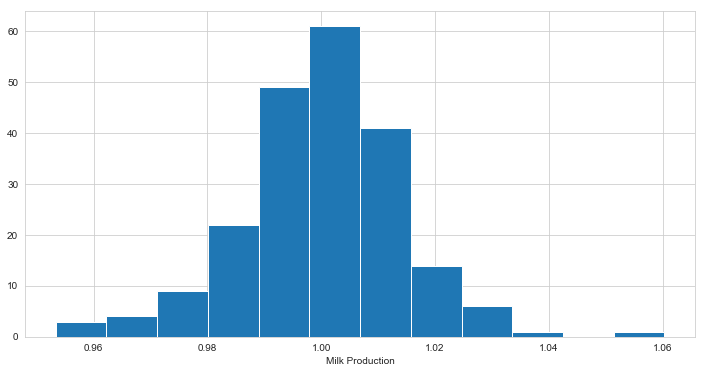

In [16]:
hist(df, 'residual', bins=12)

The distribution of the remainder values is much closer to a Normal distribution than for the original time series. This result, combined with the ACF plot, indicates that the stl decomposition is effective.  

You will further, investigate the remainder (non-seasonal residual) component by making a box plot by month of the year. 

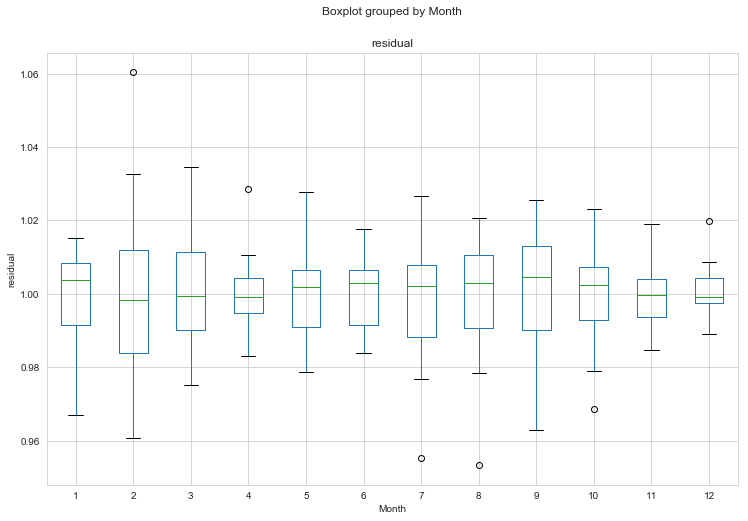

In [17]:
def box(df, col, by):
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca()
    df.boxplot(column=col, by=by, ax=ax)
    ax.set_xlabel(by)
    ax.set_ylabel(col)
box(df, 'residual', by = 'Month')

## Exploring the Multiplicative Model with lowess

Having tried a simple moving average decomposition, we will now use a lowess model to determine the trend. Lowess is a sophisticated non-linear regression. The lowess trend model is combined with a moving window seasonal component model into the R **stl** function.   

The code in the cell below uses **stl** to decompose a time series. Plots are created of the components of the time series. Finally, the columns of the time series decomposition are added as new column to input data frame. Execute the code in the cell below to compute and view a decomposition of the milk production time series.

In [18]:
import pandas as pd
from rpy2.robjects import r, pandas2ri
import numpy as np
from rpy2.robjects.packages import importr

def stl_decompose(df, col, s_window = 'periodic', mult = True,  span = 0.5):
#     df = pd.DataFrame()
    df['date'] = df[col].index
    if mult: 
        series = df[col].pipe(np.log)
        frequency = 12
    else:
        series = df[col]
        frequency = 24
    s = [x for x in series.values]
    length = len(series)
    span = span * length
    s = r.ts(s, frequency=frequency, start=1) # s is ts object (of r)
    decomposed = [x for x in r.stl(s, s_window, t_window = span).rx2('time.series')]
    df['observed_stl'] = series.values
    df['trend_stl'] = decomposed[length:2*length]
    df['seasonal_stl'] = decomposed[0:length]
    df['residual_stl'] = decomposed[2*length:3*length]
    return df

In [19]:
df_loess = stl_decompose(df, col = 'Milk.Prod', mult=True, span = 0.5)
df_loess.head()

,Month,Year,Milk.Prod,day,date_time,Milk.Prod_12,residual,date,observed_stl,trend_stl,seasonal_stl,residual_stl
date_time,,,,,,,,,,,,
1995-12-01,12,1995,2.091,1,1995-12-01,2.110583,0.989159,1995-12-01,0.737642,0.736258,-0.001236,0.002620
1996-01-01,1,1996,2.109,1,1996-01-01,2.110333,0.985808,1996-01-01,0.746214,0.740577,0.010059,-0.004422
1996-02-01,2,1996,1.996,1,1996-02-01,2.115667,1.003770,1996-02-01,0.691145,0.744896,-0.063136,0.009385
1996-03-01,3,1996,2.173,1,1996-03-01,2.116583,0.977846,1996-03-01,0.776109,0.749216,0.046721,-0.019828
1996-04-01,4,1996,2.163,1,1996-04-01,2.119333,0.989632,1996-04-01,0.771496,0.753535,0.026479,-0.008518


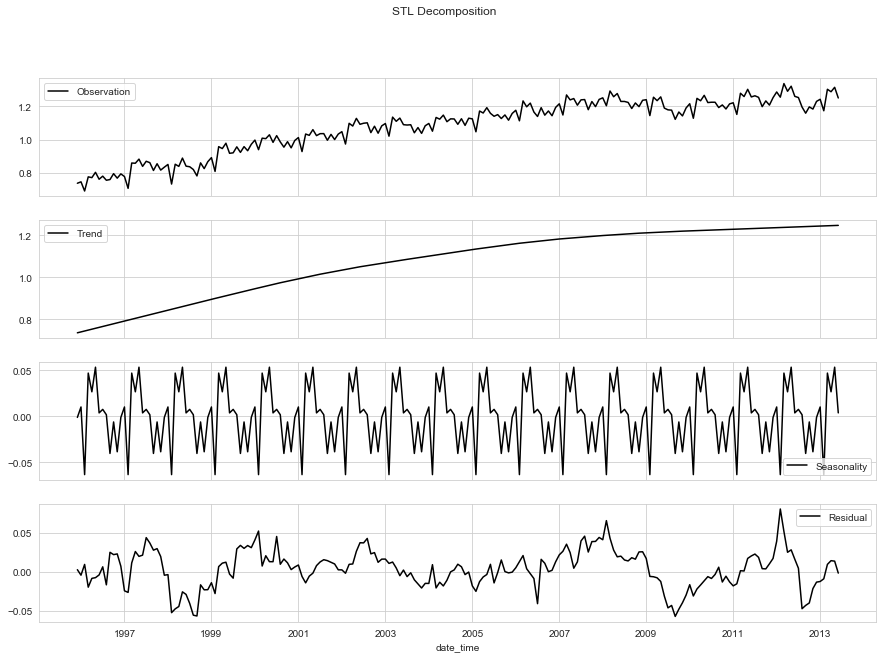

In [20]:
def plot_decomp(df, observation, trend, seasonal, residual):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True,figsize=(15,10))
    df.plot(y=observation, use_index=True, ax=ax1, label='Observation', c = 'black')
    df.plot(y=trend, use_index=True, ax=ax2, label='Trend', c='black')
    df.plot(y=seasonal, use_index=True, ax=ax3, label='Seasonality', c='black')
    df.plot(y=residual, use_index=True, ax=ax4, label='Residual', c='black')  
    fig.suptitle('STL Decomposition')
    
plot_decomp(df_loess, 'observed_stl', 'trend_stl', 'seasonal_stl', 'residual_stl')

The time series charts show the original time series along with the components of the decomposition. The trend is a bit smoother than was obtained with the simple moving average decomposition. 

The question remains, is the remainder from this decomposition stationary? To find out, lets make acf plot. 

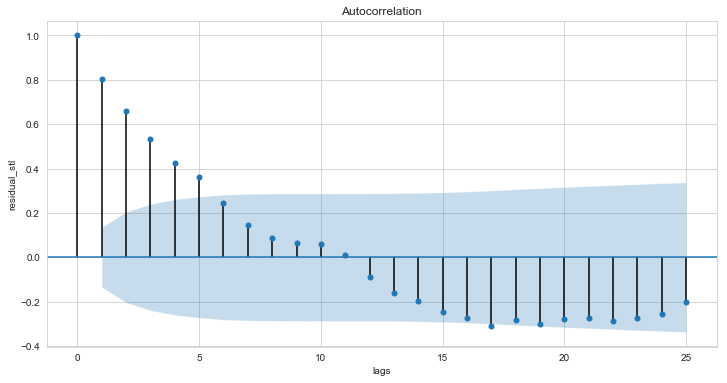

In [21]:
acf(df_loess, 'residual_stl')

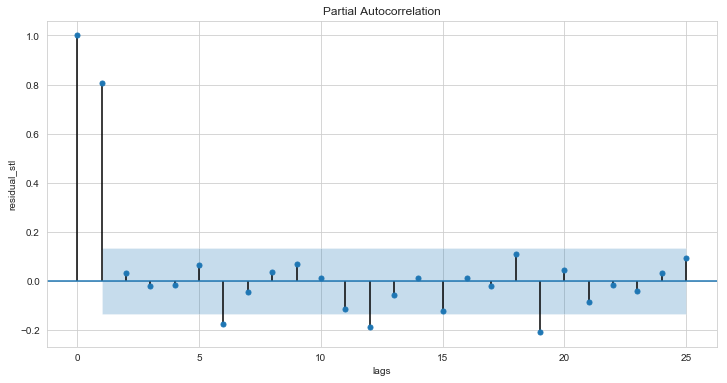

In [22]:
pacf(df_loess, 'residual_stl')

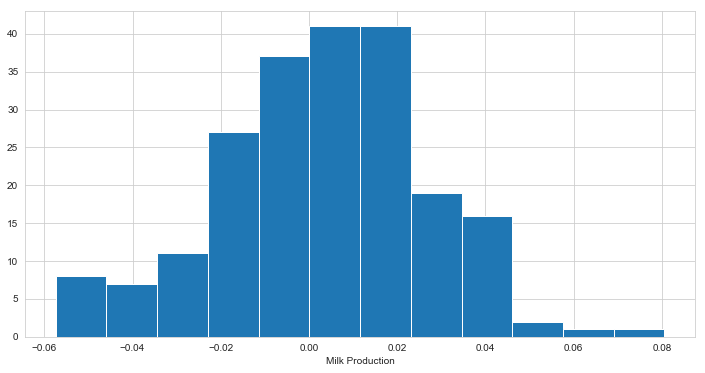

In [23]:
hist(df_loess, 'residual_stl', bins=12)

The distribution of the remainder values is much closer to a Normal distribution than for the original time series. This result, combined with the ACF plot, indicates that the stl decomposition is effective.  

Lets further investigate the remainder (non-seasonal residual) component by making a box plot by month of the year. The code in the cell below plots a box plot by month of the remainder component.

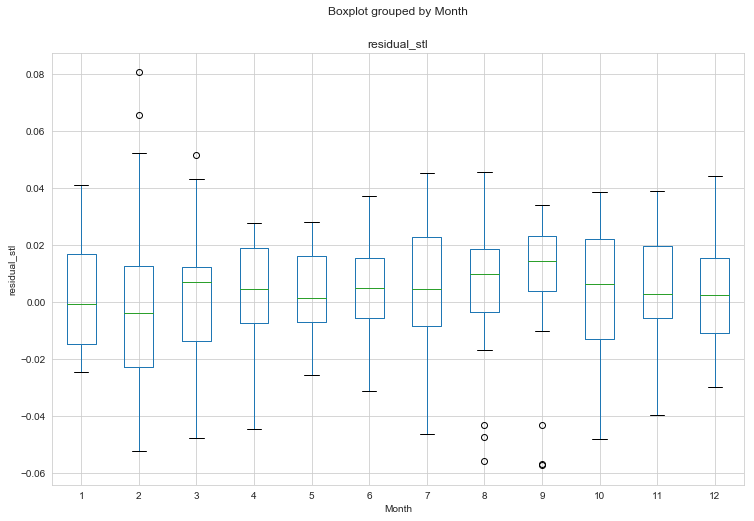

In [24]:
box(df=df_loess, col='residual_stl', by='Month')

The remainder component shows only limited vairation from month to month. The differences are within the interquartile range, indicating that the seasonal model is a reasonably good fit. 

## Moving Average Models

Now that we have explored the decomposition of the time series we, will now construct and test Autoregressive Moving Average (ARMA) models for the remainder of the time series. We will create and test these models in three steps:
* creating a moving average (MA) model
* creating an autoregressive (AR) model
* creating an autoregressive moving average (ARMA) model. 

The function in the cell below computes an Autoregressive Integrative Moving Average (ARIMA) model. The summary statistics for the model are printed and the model object returned. By assigning values to the order of each operator different time series models can be specified, as order of MA model, order of Integrative model, and order of AR model. Since the de-trended remainder is being modeled, the **include.mean** argument is set to FALSE in the **arima** function. 

The ACF of the remainder from the **stl** decomposition of the milk production time series had 4 significant lag values. As an inital model, you will now create an MA model of order 4. Execute the code in the cell below to compute the MA(4) model and examine the model summary. 

C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:           residual_stl   No. Observations:                  211
Model:                     ARMA(0, 3)   Log Likelihood                 591.050
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sat, 26 Jan 2019   AIC                          -1172.101
Time:                        18:38:43   BIC                          -1155.342
Sample:                    12-01-1995   HQIC                         -1165.327
                         - 06-01-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0035      0.003      1.240      0.216      -0.002       0.009
ma.L1.residual_stl     0.8126      0.064     12.623      0.000       0.686       0.939
ma.L2.residual_stl  

,resid
count,211.000000
mean,0.000004
std,0.014704
min,-0.051665
25%,-0.008477
50%,0.000679
75%,0.006916
max,0.050381


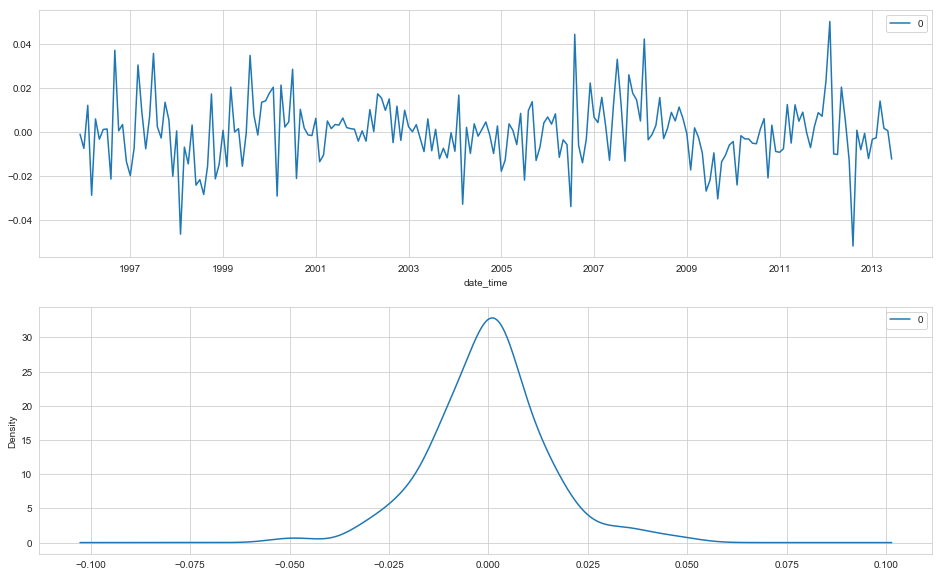

In [25]:
def arima_model(df, col, order):
    from statsmodels.tsa.arima_model import ARIMA
    model = ARIMA(df[col], order=order) #index should be datetime object
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    residual = model_fit.resid
    resid = pd.DataFrame(residual)
#     print residual
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(16,10))
    resid.plot(ax=ax1)
    resid.plot(kind='kde', ax=ax2)
    return resid.rename(columns={0: 'resid'})
res_ma = arima_model(df_loess, 'residual_stl', order=(0,0,3))
res_ma.describe()

Examine the values of the model coefficients and their standard errors (SE). Notice that the SE of the ma4 coefficient is actually greater than the value of the coefficient itself. This indicates that the value of this coefficient is poorly deterimined and should likely be set to zero. 

The foregoing result indicates that the order of the MA model should be reduced. Generally, the order of an MA model is reduced in unit steps until all the coefficients appear to be significant. 
The small standard error compared to the magnitude of the coefficients indicates that the order of the model is reasonable. 

To test how well this model fits the data, and results in a stationary result, you will plot the ACF of the residuals of the MA(3) model. 

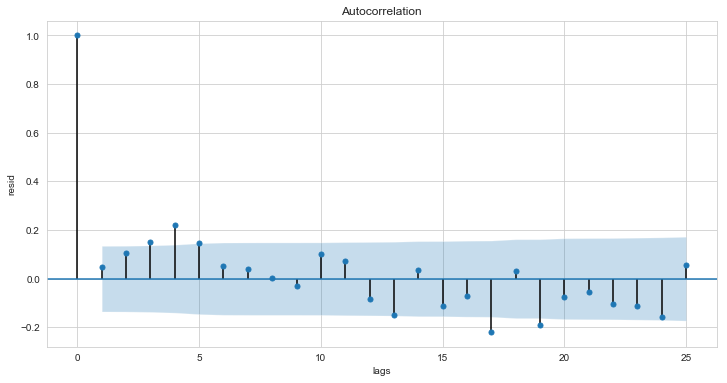

In [26]:
acf(res_ma, 'resid')

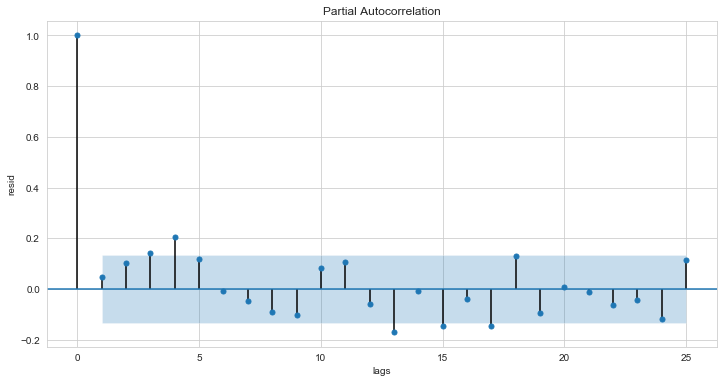

In [27]:
pacf(res_ma, 'resid')

Note that only the 0 lag of the ACF is significant and that there are no significant lags for the PACS. These observations indicate that the MA(3) model is a good fit.

## Autoregressive Models

The MA(3) model has been shown to be effective. Next, we will test an autoregressive model. The PACF of the reminder indicates that an AR model might not be the best choice. None the less, a low order AR model might fit these data. Lets start by computing AR(2) model. 

C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\scipy\signal\signaltools.py:1026: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\scipy\signal\signaltools.py:1029: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramDa

                              ARMA Model Results                              
Dep. Variable:           residual_stl   No. Observations:                  211
Model:                     ARMA(1, 0)   Log Likelihood                 597.791
Method:                       css-mle   S.D. of innovations              0.014
Date:                Sat, 26 Jan 2019   AIC                          -1189.581
Time:                        18:39:03   BIC                          -1179.526
Sample:                    12-01-1995   HQIC                         -1185.517
                         - 06-01-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0035      0.005      0.732      0.465      -0.006       0.013
ar.L1.residual_stl     0.7978      0.041     19.578      0.000       0.718       0.878
                    

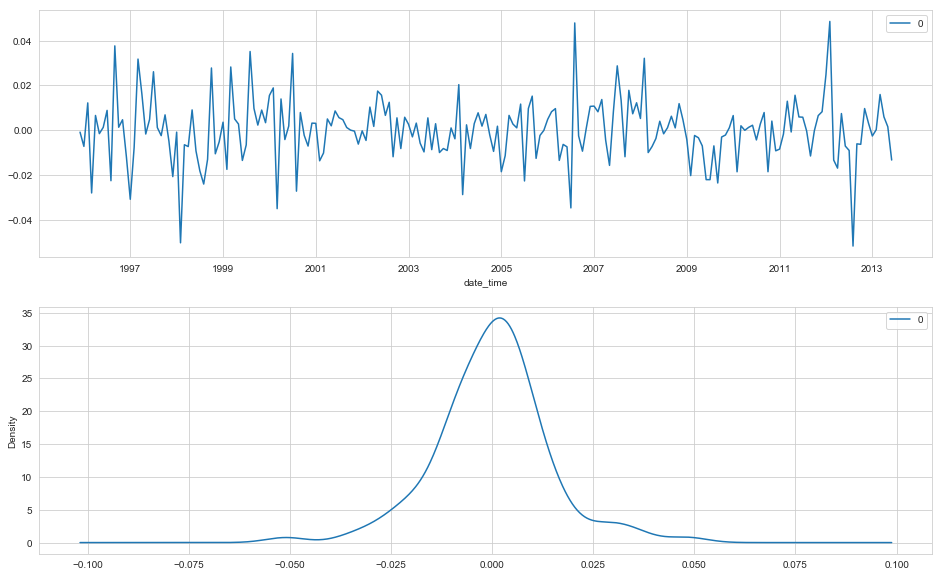

In [28]:
res_ar = arima_model(df_loess, 'residual_stl', order=(1,0,0))

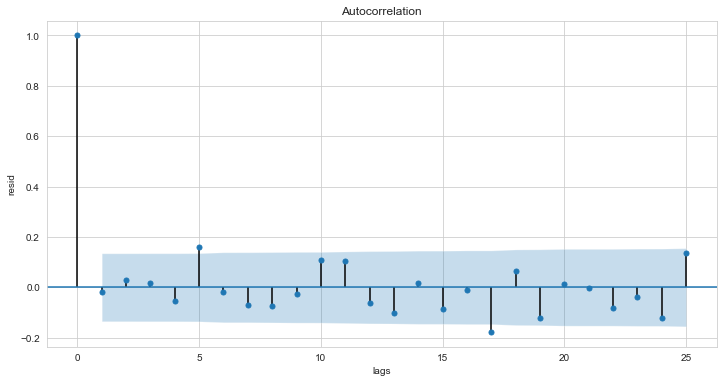

In [29]:
acf(res_ar, 'resid')

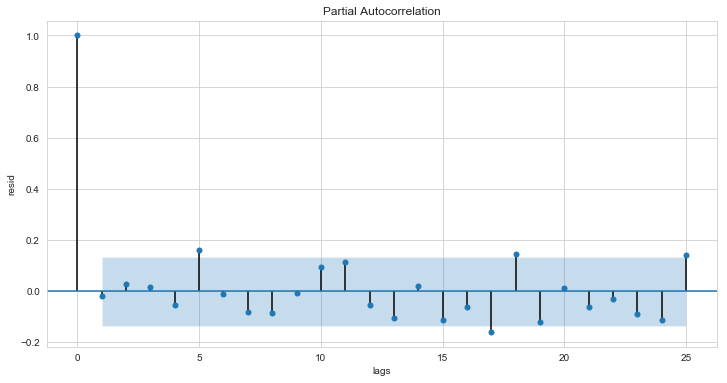

In [30]:
pacf(res_ar, 'resid')

Note that only the 0 lag of the ACF is significant and that there are no significant lags for the PACF. These observations indicate that the AR(1) model is a good fit. Compare these results to those of the MA(3) model, noting that they are nearly identical. Evidently, either the MA(3) or AR(1) model is a good choice for these data. 

## Autoregressive Moving Average Models

You have found that both MA(3) and AR(1) models are good fits to the remainder series. You will now investigate the use of autoregressive moving average (ARMA) models on the remainder series. 

As a starting point lets try an ARMA(1,3) model.

C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:           residual_stl   No. Observations:                  211
Model:                     ARMA(1, 3)   Log Likelihood                 597.929
Method:                       css-mle   S.D. of innovations              0.014
Date:                Sat, 26 Jan 2019   AIC                          -1183.858
Time:                        18:39:06   BIC                          -1163.747
Sample:                    12-01-1995   HQIC                         -1175.729
                         - 06-01-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0035      0.005      0.727      0.468      -0.006       0.013
ar.L1.residual_stl     0.7974      0.074     10.761      0.000       0.652       0.943
ma.L1.residual_stl  

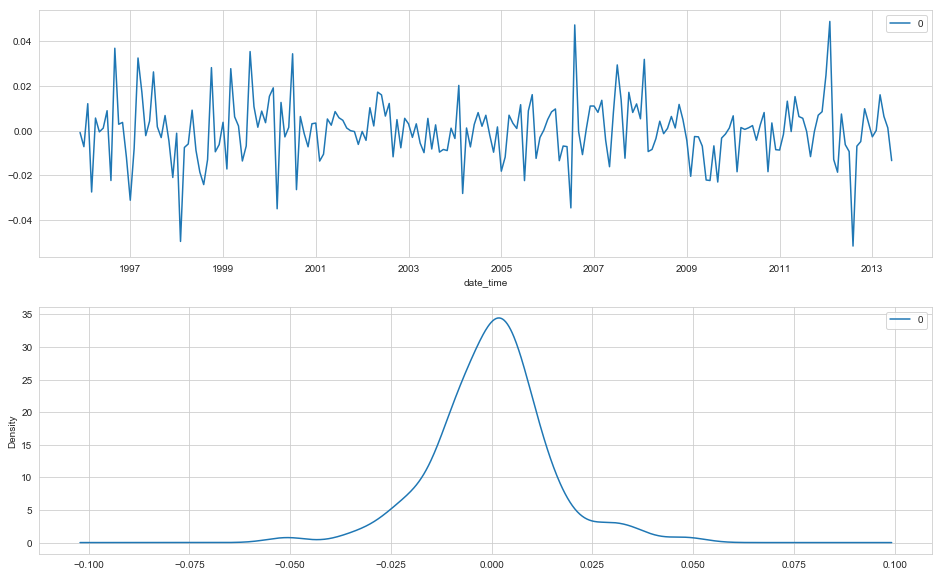

In [31]:
res_arma = arima_model(df_loess, 'residual_stl', order=(1,0,3))

In most cases, the standard error is of the same order of magnitude as the value of the coefficient, indicating this model is a poor fit to the data.

## Exploring the Difference Series

Using a difference series is a method to remove trend from a time series. The difference can be computed for any number of lag values, depending on the order of the trend.  In this case we will use a first order difference series to model the trend in the milk production time series. 

Lets explore that how the differencing removes the trend of a ts. The difference series is  necessarily of length one less than the original series. 

In [41]:
df.head()

,Month,Year,Milk.Prod,day,date_time,Milk.Prod_12,residual,date,observed_stl,trend_stl,seasonal_stl,residual_stl
date_time,,,,,,,,,,,,
1995-12-01,12,1995,2.091,1,1995-12-01,2.110583,0.989159,1995-12-01,0.737642,0.736258,-0.001236,0.002620
1996-01-01,1,1996,2.109,1,1996-01-01,2.110333,0.985808,1996-01-01,0.746214,0.740577,0.010059,-0.004422
1996-02-01,2,1996,1.996,1,1996-02-01,2.115667,1.003770,1996-02-01,0.691145,0.744896,-0.063136,0.009385
1996-03-01,3,1996,2.173,1,1996-03-01,2.116583,0.977846,1996-03-01,0.776109,0.749216,0.046721,-0.019828
1996-04-01,4,1996,2.163,1,1996-04-01,2.119333,0.989632,1996-04-01,0.771496,0.753535,0.026479,-0.008518


In [46]:
def diff(df, col, col_out):
    dfa = pd.DataFrame()
    dfa = df.copy()
    dfa[col_out] = df[col].diff(periods=1)
    dfa = dfa.dropna() # dfa[col_out] has n-1 elements
    return dfa
df_diff = diff(df=df, col='Milk.Prod', col_out = 'Milk.Diff')
df_diff.head()

Next, compute the stl decomposition of the difference series. Since we are working with a difference series, which has positive and negative values, we use an additive model. No logarithm is taken.  

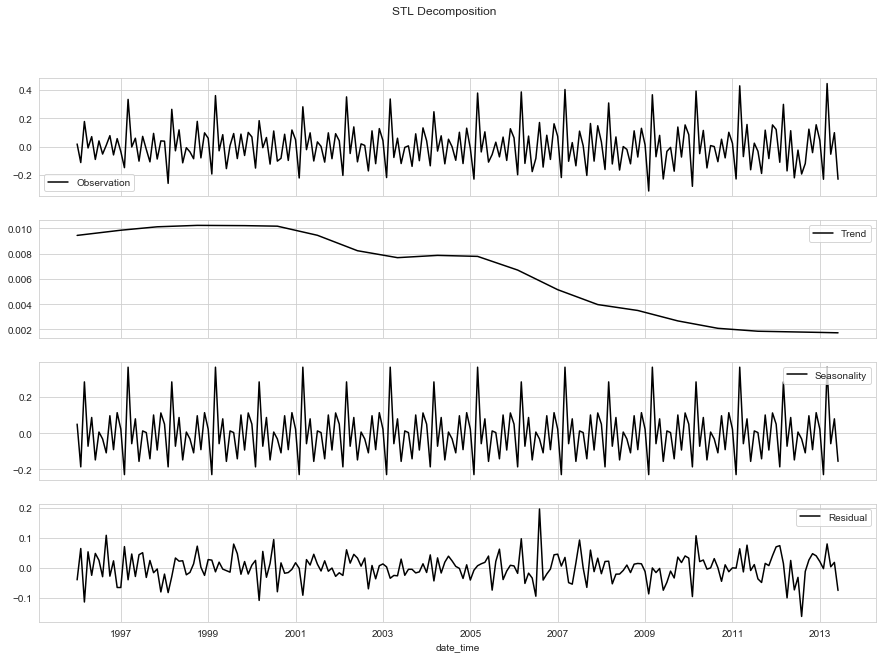

In [52]:
df_diff_decompose = stl_decompose(df_diff, 'Milk.Diff', s_window='periodic', mult=False, span=0.5)
plot_decomp(df_diff_decompose, 'observed_stl', 'trend_stl', 'seasonal_stl', 'residual_stl')

Examine the results shown above. The difference series is shown in the uppermost plot. Notice the small magnitude of the remaining trend indicating that the first order difference model removed most of the trend. However, the seasonal series exhibits a pattern with a 24 month cycle which is a bit odd. 

****

### Exercise: Analysis of the Difference Series

In this exercise you will analyize the remainder of the difference series following these steps. 

- Does the acf plot indicate that the remainder series is stationary?  
- Is the dispersion of these values greater or less than the dispersion obtained directly from the decomposition of the time series (without diferencing). 
- Is the interquartile range of these values greater or less than the interquartile range obtained directly from the decomposition of the time series (without differencing). 

In the code cell below, use the **dairy.acf**, **dairy.hist**, and **dairy.box** functions to create new plots of the difference series and answer the questions above. 
****

In [54]:
df_diff_decompose.head()

,Month,Year,Milk.Prod,day,date_time,Milk.Prod_12,residual,date,observed_stl,trend_stl,seasonal_stl,residual_stl,Milk.Diff
date_time,,,,,,,,,,,,,
1996-01-01,1,1996,2.109,1,1996-01-01,2.110333,0.985808,1996-01-01,0.018,0.009450,0.049358,-0.040808,0.018
1996-02-01,2,1996,1.996,1,1996-02-01,2.115667,1.003770,1996-02-01,-0.113,0.009485,-0.186614,0.064129,-0.113
1996-03-01,3,1996,2.173,1,1996-03-01,2.116583,0.977846,1996-03-01,0.177,0.009520,0.282530,-0.115049,0.177
1996-04-01,4,1996,2.163,1,1996-04-01,2.119333,0.989632,1996-04-01,-0.010,0.009554,-0.072660,0.053106,-0.010
1996-05-01,5,1996,2.233,1,1996-05-01,2.119833,0.990229,1996-05-01,0.070,0.009589,0.086042,-0.025631,0.070


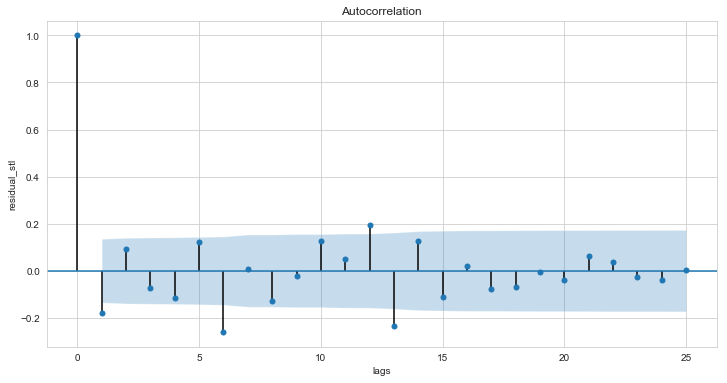

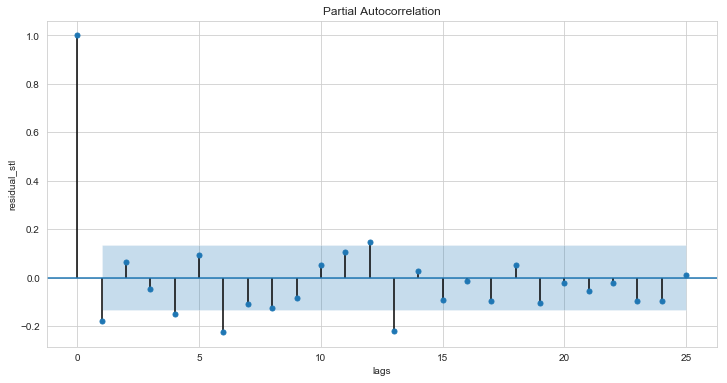

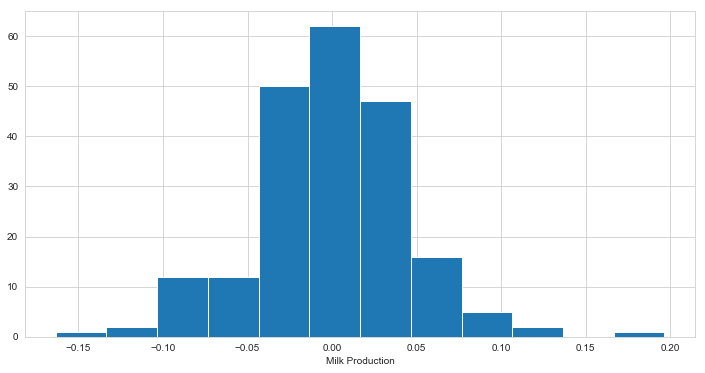

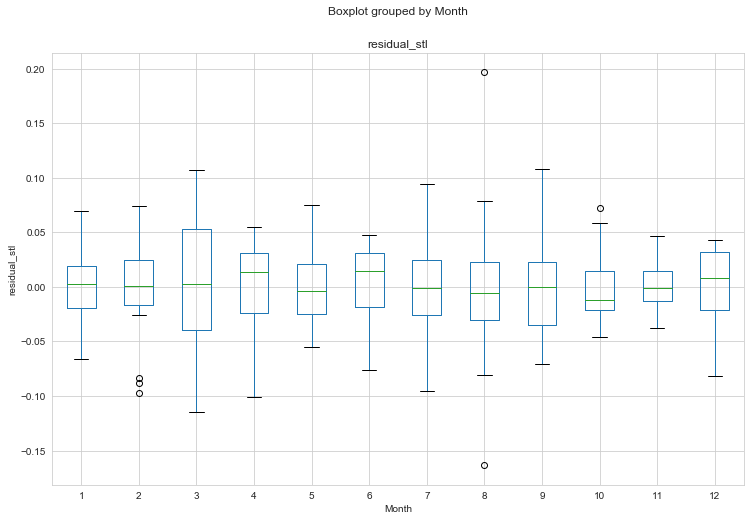

In [53]:
acf(df_diff_decompose, 'residual_stl')
pacf(df_diff_decompose, 'residual_stl')
hist(df_diff_decompose, 'residual_stl', bins=12)
box(df_diff_decompose, 'residual_stl', by='Month')

## Autoregressive Integrative Moving Average Model

It is clear from the exploration of the ARMA model, that the remainder of the decomposition of the dairy production time series is not stationary. You will now model the remainder series with an autoregressive integrative moving average (ARIMA) model.

Lets compute an ARIMA(1,1,1) model.

C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:         D.residual_stl   No. Observations:                  210
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 593.382
Method:                       css-mle   S.D. of innovations              0.014
Date:                Sun, 27 Jan 2019   AIC                          -1178.764
Time:                        14:11:46   BIC                          -1165.376
Sample:                    01-01-1996   HQIC                         -1173.352
                         - 06-01-2013                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.707e-06   7.84e-05     -0.047      0.962      -0.000       0.000
ar.L1.D.residual_stl     0.8062      0.042     19.332      0.000       0.724       0.888
ma.L1.D.resi

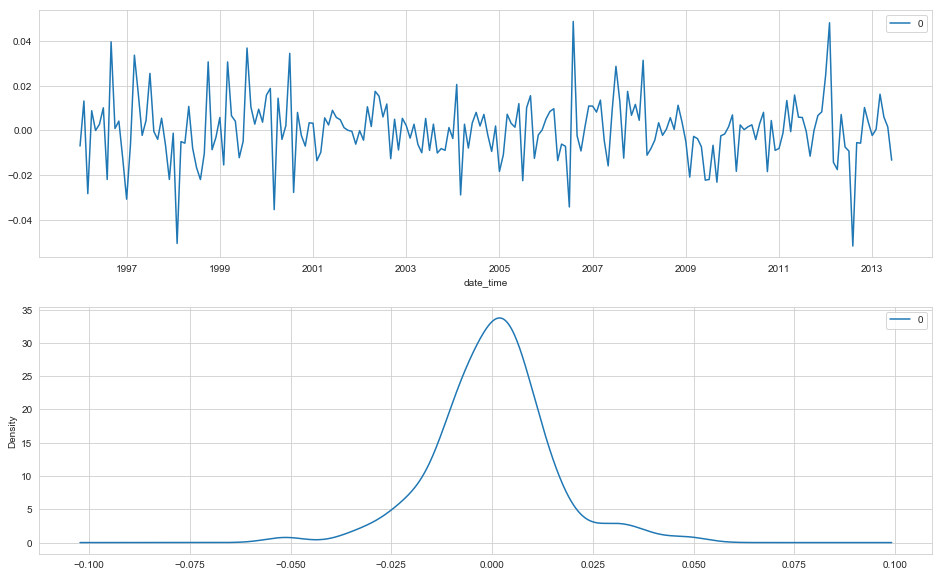

In [55]:
res_arima = arima_model(df_loess, 'residual_stl', order=(1,1,1))

The standard error of the ar1 coeficient is only about half its value. This model seems to be a reasonable fit. 

Next, plot the ACF and PACF of the model.

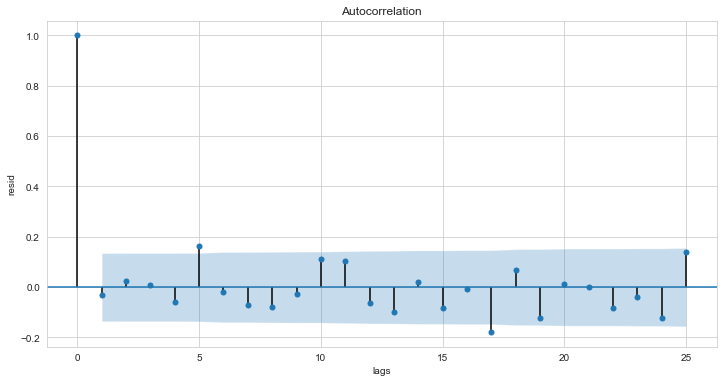

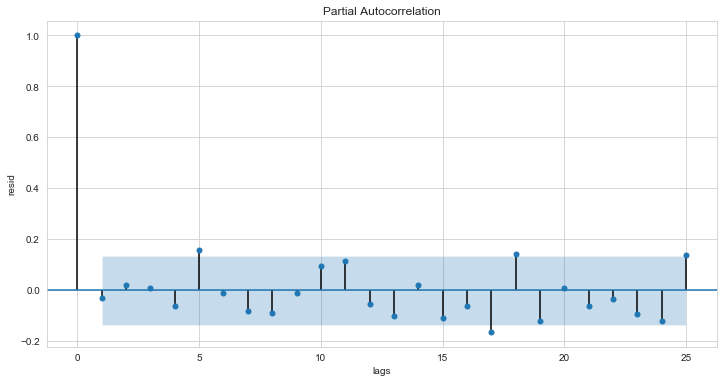

In [56]:
acf(res_arima, 'resid')
pacf(res_arima, 'resid')

Note that only the 0 lag of the ACF is significant and that there are no significant lags for the PACF. These observations indicate that the ARIMA(1,1,1) model is a good fit. Compare these results to those of the MA(3) and AR(1) models, noting that they are nearly identical. The ARIMA(1,1,1) model is a good choice for these data as well. 

## Summary

In this lab you have learned to work with and analyze time series data. Specifically, you have done the following:

- Examined the properties of time series objects.
- Plotted time series data.
- Decomposed time series data into its trend, seasonal, and remainder components.
- Modeled the remainder components as AR, MA, ARMA and ARIMA models. 
- Created and evaluated difference series methods.